<a href="https://colab.research.google.com/github/felipemaiapolo/analise_sentimentos_PMR3508/blob/main/introducao_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução ao Doc2Vec

#### Disciplina: PMR3508 - Aprendizado de Máquina e Reconhecimento de Padrões

O objetivo deste notebook é a introdução prática ao modelo de processamento de linguagem natural Doc2Vec. O modelo Doc2Vec é um ótimo exemplo de como as Redes Neurais Artificiais podem ser utilizadas para gerar representações estruturadas para dados, a princípio, não estruturados. Neste material, nosso foco será em mostrar como treinar e utilizar esse modelo em Python, além de dar uma intuição de como o modelo é treinado e de como é feita a inferência das representações para textos que não estão no conjunto de treinamento.

### Base de dados que utilizaremos

Os dados utilizados neste notebook podem ser encontradas em https://ai.stanford.edu/~amaas/data/sentiment/ em sua forma bruta. Gostaríamos de agradecer aos autores de [0] por disponibilizarem os dados!


### Referências

[0] Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

### Iniciando...


Importando bibliotecas necessárias:

In [ ]:
#Para o uso geral
import random
import numpy as np
import pandas as pd
import copy 
import time
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
import requests
import io

#Para o processamento de textos
from ftfy import fix_text
import string
import re
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec

Para o treinamento do Doc2Vec, utilizaremos dados não rotulados. Ou seja, somente os textos das avaliações sobre os filmes!

Vamos abrir a base de avaliações não rotuladas:

In [ ]:
%%time
download = requests.get("https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/unsup.csv").content
data = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',')

Wall time: 25.2 s


Visualizando base de dados:

In [ ]:
data.head()

,review
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


Vendo o shape dos dados:

In [ ]:
data.shape

(49965, 1)

Vamos checar se há textos duplicados e especular se deveriam estar duplicados ou não:

In [ ]:
data.loc[data.duplicated(subset='review', keep=False)==True].sort_values(by='review').head(10)

,review
46126,"""23"" is one of the best german movies for a lo..."
46125,"""23"" is one of the best german movies for a lo..."
4342,"""Bambi 2"" is one of those rare cases which one..."
24761,"""Bambi 2"" is one of those rare cases which one..."
24261,"""FrÃ¼hling auf dem Eis"" shows a large number o..."
24246,"""FrÃ¼hling auf dem Eis"" shows a large number o..."
3938,"""I just want to get my clothes on and get the ..."
18039,"""I just want to get my clothes on and get the ..."
12010,"""No Good Deed"" is a way-above-average characte..."
49333,"""No Good Deed"" is a way-above-average characte..."


Pelo fato de as avaliações duplicadas não serem muito simples, é provável que as duplicações se devam a erros na coleta dos dados e não duplicações que poderiam de fato ocorrer. Então, vamos excluir uma das avaliações duplicadas:

In [ ]:
data=data.drop_duplicates(subset='review', keep='first')
data.shape

(49473, 1)

Vamos passar nossos textos para o formato de lista:

In [ ]:
texts=data['review'].tolist()

Checando um texto da lista:

In [ ]:
texts[0]

'I admit, the great majority of films released before say 1933 are just not for me. Of the dozen or so "major" silents I have viewed, one I loved (The Crowd), and two were very good (The Last Command and City Lights, that latter Chaplin circa 1931).<br /><br />So I was apprehensive about this one, and humor is often difficult to appreciate (uh, enjoy) decades later. I did like the lead actors, but thought little of the film.<br /><br />One intriguing sequence. Early on, the guys are supposed to get "de-loused" and for about three minutes, fully dressed, do some schtick. In the background, perhaps three dozen men pass by, all naked, white and black (WWI ?), and for most, their butts, part or full backside, are shown. Was this an early variation of beefcake courtesy of Howard Hughes?'

Definindo uma função para a limpeza dos textos. Note que a função que utilizaremos para a limpeza deve ser também utilizada quando fizermos uso do modelo treinado:

In [ ]:
def clean(text):
    txt=text.replace("<br />"," ") #retirando tags
    txt=fix_text(txt) #consertando Mojibakes (Ver https://pypi.org/project/ftfy/)
    txt=txt.lower() #passando tudo para minúsculo
    txt=txt.translate(str.maketrans('', '', string.punctuation)) #retirando toda pontuação
    txt=txt.replace(" — ", " ") #retirando hífens
    txt=re.sub("\d+", ' <number> ', txt) #colocando um token especial para os números
    txt=re.sub(' +', ' ', txt) #deletando espaços extras
    return txt

Limpando cada um dos textos:

In [ ]:
%%time
texts=[clean(t) for t in texts]

Wall time: 1min 56s


Checando o mesmo texto de forma limpa:

In [ ]:
texts[0]

'i admit the great majority of films released before say <number> are just not for me of the dozen or so major silents i have viewed one i loved the crowd and two were very good the last command and city lights that latter chaplin circa <number> so i was apprehensive about this one and humor is often difficult to appreciate uh enjoy decades later i did like the lead actors but thought little of the film one intriguing sequence early on the guys are supposed to get deloused and for about three minutes fully dressed do some schtick in the background perhaps three dozen men pass by all naked white and black wwi and for most their butts part or full backside are shown was this an early variation of beefcake courtesy of howard hughes'

Tokenizando os textos:

In [ ]:
tokens=[t.split() for t in texts]

Vendo o mesmo texto, mas dessa vez tokenizado:

In [ ]:
tokens[0][:20]

['i',
 'admit',
 'the',
 'great',
 'majority',
 'of',
 'films',
 'released',
 'before',
 'say',
 '<number>',
 'are',
 'just',
 'not',
 'for',
 'me',
 'of',
 'the',
 'dozen',
 'or']

### O modelo Doc2Vec

Vamos fazer uma breve introdução ao modelo **Doc2Vec** para a a geração de representações de textos (embeddings) de uma forma fácil e rápida. O modelo **Doc2Vec** é do ano de 2014 e foi descrito pela primeira por pesquisadores do Google no artigo [1] - as duas últimas imagens utilizadas a seguir foram retiradas deste artigo - infelizmente não encontrei a fonte da primeira imagem. 

Um tutorial bem didático de como a técnica funciona pode ser acessado no link [2] e a documentação do método está em [3]. Antes de explicar como é o funcionamento do modelo **Doc2Vec** é necessário entender como o modelo **Word2Vec**, para o cálculo de representações para palavras, funciona. O modelo **Word2Vec** é um modelo que gera representações vetoriais para palavras de acordo com os contextos em que as palavras aparecem nos textos da nossa base de dados. Dessa maneira é possível pensar que a palavra 'rei' está para 'homem' assim como 'rainha' está para 'mulher' como na figura abaixo:

<figure>
<center>
<img src='https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/word2vec.png' />
</center>
</figure>

É impressionante ver o poder de uma técnica relativamente simples que é o **Word2Vec**. Existem basicamente duas versões de modelos para o **Word2Vec**, a COBW (Continuous Bag of Words) e Skip-Gram - aqui focaremos basicamente na primeira abordagem. A abordagem COBW considera que a posição das palavras podem ser preditas pelo contextos nas quais estão inseridas (palavras no entorno). Chamamos esse contexto de 'janela'. Todas as palavras do vocabulário começam com uma representação aleatória que o modelo melhora de acordo com o processo de aprendizagem ao tentar predizer a presença de palavras pelos contextos nos quais estão inseridas. Assim cada palavra adquire uma representação compatível com os contextos em que geralmente essa palavra aparece. Temos então o seguinte esquema para uma implementação do **Word2Vec** COBW:

<figure>
<center>
<img src='https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/word2vec2.png' />
</center>
</figure>

Agora que entendemos um pouco melhor como funciona o modelo **Word2Vec**, podemos entender como é o funcionamento do **Doc2Vec**. O segundo modelo acaba sendo uma extensão do primeiro. Assim como o **Word2Vec**, o modelo **Doc2Vec** tem duas versões principais e aqui focaremos naquela análoga ao COBW, que se chama PV-DM (Distributed Memory version of Paragraph Vector). A ideia continua igual, no entanto adicionamos um vetor específico para cada um dos documentos a fim de predizer as palavras daquele documento específico. Quando formos treinar o modelo **Doc2vec** basta fornecermos os parâmetros 'window' (para o tamanho da janela) e 'size' para o tamanho dos embeddings (representações dos textos).

<figure>
<center>
<img src='https://raw.githubusercontent.com/felipemaiapolo/hands-on_ic_ml/master/doc2vec.png' />
</center>
</figure>

Fontes:

1. Le, Q., & Mikolov, T. (2014, January). Distributed representations of sentences and documents. In International conference on machine learning (pp. 1188-1196). 
Link: https://cs.stanford.edu/~quocle/paragraph_vector.pdf
2. https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
3. https://radimrehurek.com/gensim/models/doc2vec.html

### Treinando Doc2Vec

Especificando hiperparâmetros para treinar modelo Doc2Vec. Neste caso 'window' se refere à distância máxima (em número de palavras) entre as palavras a serem inferidas e aquelas consideradas de contexto.

In [ ]:
size=50
window=10

Treinando modelo:

In [ ]:
%%time

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]
model = Doc2Vec(documents, vector_size=size, window=window, dm_mean=1, epochs=10)

Wall time: 5min 4s


Salvando modelo em disco:

In [ ]:
model.save('models/doc2vec')

### Utilizando o modelo Doc2Vec pré-treinado

Carregando modelo:

In [ ]:
d2v = Doc2Vec.load('models/doc2vec')  

A inferência do vetor para um texto específico é feita utilizando a descida pela gradiente, congelando a rede neural do Doc2Vec e atualizando somente os pesos referentes ao novo texto. Na função abaixo, fixamos uma semente (*seed*) afim de garantir resultados reprodutíveis e definimos que a descida pelo gradiente dê 20 passos.

Definindo função que fará o embedding:

In [ ]:
def emb(string, model, normalize=False): 
    model.random.seed(42)
    x=model.infer_vector(string, steps=20)
    
    if normalize: return(x/np.sqrt(x@x))
    else: return(x)

Obtendo o embedding de um texto tokenizado:

In [ ]:
emb(tokens[0], d2v)

array([-0.5025875 , -0.3447058 ,  0.13436049,  0.39018333, -0.10440361,
        0.11720716, -0.08191961, -0.46607956, -0.6303297 ,  0.5215501 ,
        0.04060352, -1.1570293 , -0.5104716 , -0.33255166, -0.12884223,
       -0.07033547,  0.30809197,  0.5168081 ,  0.07482839, -1.0800563 ,
        0.19084787, -0.7333135 ,  0.38773566,  0.2852471 ,  0.26840484,
       -0.29038674, -0.63251245, -0.26511842,  0.48513424,  0.19414012,
        0.3566959 , -0.93202865,  0.5822806 , -1.0152892 , -0.85993165,
       -0.3172352 , -0.18244594,  1.3446668 , -0.47776607,  0.39075905,
       -0.38342026, -0.00394523, -0.27024877, -0.43286872,  0.99878204,
        1.2279924 ,  0.384848  , -0.32819253, -0.3062895 , -0.3418168 ],
      dtype=float32)

#### Rrepresentações vetoriais para palavras

Um bônus em treinar um modelo Doc2Vec é que também temos necessariamento as representações para palavras (Word2Vec) que aparecem nos textos. 

Vamos ver uma delas:

In [ ]:
d2v['good']

array([-1.1557218 , -1.7600553 ,  1.2216235 ,  1.8812038 ,  0.68748534,
       -0.30647802,  2.5037978 , -1.6115426 , -1.4925867 ,  0.51079017,
        0.85061383, -1.8082415 ,  2.392079  , -0.5213814 ,  1.9120603 ,
       -2.0093987 , -0.7510775 ,  1.9731916 ,  0.36109957,  2.5094054 ,
        3.0984154 ,  3.5720563 ,  1.1022336 , -2.4284034 ,  4.692224  ,
       -1.7945781 , -1.3926803 ,  3.40962   , -3.933829  ,  2.2905967 ,
       -2.8715951 , -0.08206151,  0.7903915 ,  0.28308663,  3.3633626 ,
        0.15981482,  0.5859061 ,  0.5542446 ,  0.9774504 ,  0.5237442 ,
       -3.187714  , -0.11170991, -2.251723  ,  1.9839427 , -0.94994795,
        0.370625  , -4.0769844 ,  2.6183748 , -1.4141436 , -0.5556728 ],
      dtype=float32)

### Aplicação: Similaridade entre Textos

No contexto de NLP é comum utilizarmos a similaridade de cossenos para compararmos dois textos. É importante recordar que em nosso contexto, cada um dos textos é tratado como um vetor com comprimento, direção e sentido. Um vetor será expresso aqui na forma de matrizes unidimensionais (Numpy arrays). Um vetor de tamanho $n$ é uma lista de valores em forma matricial da seguinte forma:

\begin{equation}
  \begin{aligned}
      \mathbf{x}=\begin{pmatrix} x_1 
      \\ x_2
      \\ ...
      \\ x_n
     \end{pmatrix}
   \end{aligned}
\end{equation}

Assumindo que outro vetor $\mathbf{y}$ tenha o mesmo tamanho de $\mathbf{x}$, o cosseno do ângulo ($\theta$) entre os vetores é calculado da seguinte forma:

\begin{equation}
  \begin{aligned}
      cos(\theta)=\frac{\sum_{i=1}^{n}x_iy_i }{\sqrt{\sum_{i=1}^{n}x_i^2}\sqrt{\sum_{i=1}^{n}y_i^2}}=
      \frac{\mathbf{x}^T\mathbf{y}}{\sqrt{\mathbf{x}^T\mathbf{x}}.\sqrt{\mathbf{y}^T\mathbf{y}}}=
      \frac{\mathbf{x}^T\mathbf{y}}{\left \| \mathbf{x} \right \|.\left \| \mathbf{y} \right \|}
   \end{aligned}
\end{equation}

Se o comprimento dos vetores $\mathbf{y}$ e $\mathbf{x}$ é um, então podemos reescrever o cosseno da seguinte forma:

\begin{equation}
  \begin{aligned}
      cos(\theta)=\sum_{i=1}^{n}x_iy_i=
      \mathbf{x}^T\mathbf{y}
   \end{aligned}
\end{equation}

Para normalizar um vetor $\mathbf{x}$ para que tenha comprimento 1, basta fazer a seguinte atualização:

\begin{equation}
  \begin{aligned}
      \mathbf{x}\leftarrow \frac{\mathbf{x}}{\sqrt{\mathbf{x}^T\mathbf{x}}}
   \end{aligned}
\end{equation}

Para entender melhor, vamos definir uma função que calcula a similaridade entre dois vetores. A similaridade (cosseno) varia de -1 a 1 sendo que valores positivos indicam que os vetores têm o mesmo sentido e valores negativos nos dizem que os vetores têm sentidos opostos:

In [ ]:
def simil(x,y):
    return((x@y)/np.sqrt((x@x)*(y@y)))

Definindo dois vetores e os visualizando:

> **Atenção**: se tiver problemas ao plotar o gráfico abaixo, tentar adaptar o código para

> ```
V = np.array([v1,v2])
O=np.array([[0],[0]])
plt.quiver(O[:],O[:],V[:,0],V[:,1], color=['r','g','b'], scale=10)
plt.show()
```

> Também é possível adaptar o parâmetro `scale`.



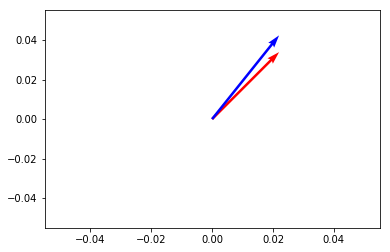

In [ ]:
v1=np.array([2,2])
v2=np.array([2,2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=10)
plt.show()

Veja que o menor ângulo entre os vetores é pequeno então a similaridade deve dar algo próximo de 1:

In [ ]:
simil(v1,v2)

0.9938837346736188

Veja que o cosseno entre os vetores não depende do tamanho dos vetores. Vamos manter o ângulo mas diminuindo o tamanho do vetor vermelho:

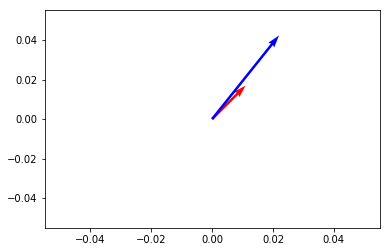

In [ ]:
v1=np.array([1,1])
v2=np.array([2,2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=10)
plt.show()

Veja que a medida de similaridade não mudou:

In [ ]:
simil(v1,v2)

0.9938837346736188

Se os vetores formam 90 graus entre si, temos que eles são ortogonais (não tem similaridade alguma entre si):

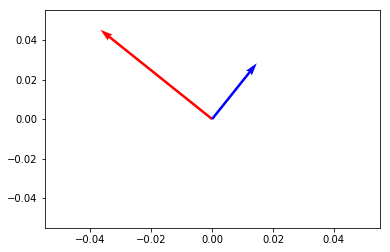

In [ ]:
v1=np.array([-5,4])
v2=np.array([2,2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=15)
plt.show()

Calculando a similaridade:

In [ ]:
simil(v1,v2)

0.0

Já se o menor ângulo entre os vetores é maior que 90 graus, ou seja, os vetores estão 'apontando' para sentidos opostos, a similaridade é negativa:

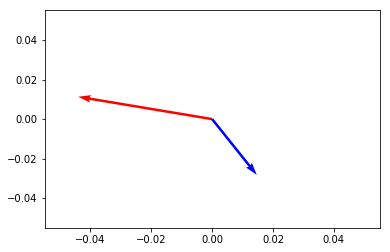

In [ ]:
v1=np.array([-6,1])
v2=np.array([2,-2.5])

V = np.array([v1,v2])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=15)
plt.show()

Similaridade:

In [ ]:
simil(v1,v2)

-0.7445694406464903

#### Dados Reais

Vamos transformar alguns dos textos tokenizados em um numpy array, em que cada linha representa um texto diferente. Vamos 'setar' a opção <code>normalize=TRUE</code>, pois tendo vetores com norma euclidiana unitária é mais fácil calcular as similaridades de cosseno:

In [ ]:
%%time
X = [emb(x, d2v, normalize=True) for x in tokens[:100]] 
X = np.array(X)

Wall time: 2.87 s


Vamos calcular as similaridades de alguns textos com eles mesmos:

In [ ]:
similaridade=X@X.T

Vamos visualizar essa matriz na forma de um heatmap:

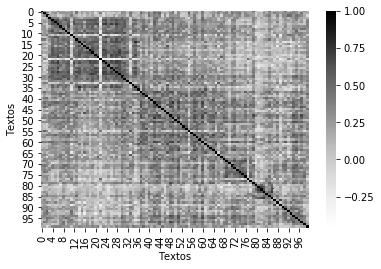

In [ ]:
sns.heatmap(similaridade, cmap="Greys")

plt.ylabel('Textos')
plt.xlabel('Textos')
plt.show()

Como esperado a diagonal principal está cheia de uns :)

Veja que calcular similaridades entre textos é uma coisa muito importante e que pode ser útil se quisermos criar clusters de textos ou utilizar algoritmos supervisionados que necessitam de uma medida para semelhança entre instâncias, e.g. KNN.

#### Clustering

Vamos criar dois clusters de textos utilizando clusterização espectral:

In [ ]:
clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0).fit(similaridade+1)

Somamos 1 às similaridades pois o algoritmo não aceita valores negativos.

Vendo labels:

In [ ]:
clustering.labels_

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

Agora vamos garantir que textos do mesmo cluster fiquem lado a lado:

In [ ]:
X=X[np.argsort(clustering.labels_)]

Recalculando as similaridades:

In [ ]:
similaridade=X@X.T

Plotando:

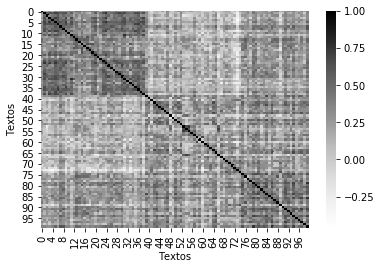

In [ ]:
sns.heatmap(similaridade, cmap="Greys")

plt.ylabel('Textos')
plt.xlabel('Textos')
plt.show()

É possível ver que temos um cluster muito bem definido, enquanto o outro não está tão bem definido assim.